# UNI2-h + PixelFPN + ASPP

After benchmarking the standalone PixelFPN decoder, we now extend it with a DeepLabV3-style ASPP module to inject richer multi-dilation context into the fused feature maps.

Goal

To evaluate whether combining explicit multi-scale fusion (PixelFPN) with multi-dilation context (ASPP) can further improve nuclei segmentation accuracy, under the same BCE + Dice loss and identical training setup

Key Idea

- The pretrained UNI2-h encoder produces a token grid that captures mid-level image features

- The PixelFPN builds a hierarchical pyramid from this grid:

    - P3: fine, high-resolution features

    - P4 / P5: progressively coarser, context-rich maps

- These multi-scale features are fused into a unified representation

- The ASPP (Atrous Spatial Pyramid Pooling) module then applies parallel dilated convolutions and global pooling to capture both local boundaries and global cell structures

- A final 1×1 convolution projects the context-enhanced map to a single-channel nuclei mask

Why It Matters

This design merges the strengths of both pyramid fusion and dilation-based context aggregation:

- PixelFPN ensures spatial precision and scale invariance

- ASPP injects long-range morphological context

The combination provides a strong, yet computationally efficient, decoder capable of capturing nuclei across diverse scales and textures, all while using a single encoder pass and standard BCE + Dice training



## Preparing the COSAS24 Dataset

This part sets up the **COSAS24 stain-agnostic nuclei dataset** for training and validation.

This code block:
1. Collects image–mask pairs from each domain in the dataset folders
2. Splits the data 80/20 by domain, so each domain contributes to both train and validation sets  
3. Applies Albumentations transforms for color, geometry, and noise augmentation
4. Builds PyTorch datasets and dataloaders, with balanced sampling to include images that contain nuclei  
5. Runs quick visual checks to make sure everything loads and aligns correctly


Device: cuda
[split]      3d-1000: train=  48 | val=  12
[split]    kfbio-400: train=  48 | val=  12
[split] teksqray-600p: train=  48 | val=  12
[totals] train=144 | val=36 | test=90
Lens: 144 36 90
[FG] b99fff65370d.png  → 1446529 positive pixels
[FG] d068d9b679a9.png  → 1457595 positive pixels
[FG] 85871ab65d9b.png  → 1595960 positive pixels
[FG] 73f40c45109e.png  → 846847 positive pixels
[FG] b59dbec94b90.png  → 2285545 positive pixels
[audit] FG in first 64 samples: 5
[Sanity] batch: torch.Size([1, 3, 1512, 1512]) torch.Size([1, 1, 1512, 1512]) | names: ['c110e2e6b88d.png']
Mask uniques: tensor([0.])


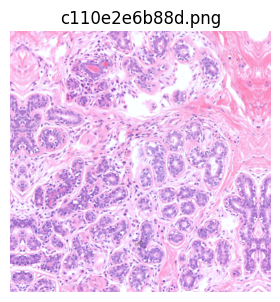

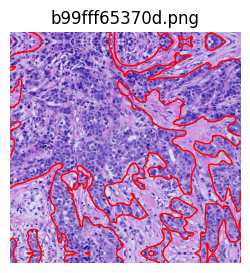

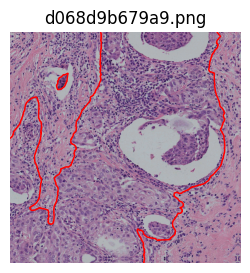

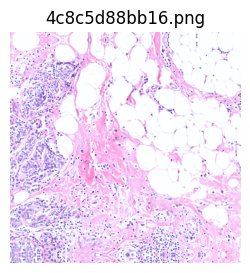

In [ ]:
import os, math, json, random, warnings
from pathlib import Path
import numpy as np, cv2, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import timm
warnings.filterwarnings("ignore", category=UserWarning)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
amp_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

DATA_ROOT = Path("/home/maria/stain_agnostic_nuclei/cosas24")   # has trainingtask2/ & final_test/
SAVE_DIR  = Path("/home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP"); SAVE_DIR.mkdir(parents=True, exist_ok=True)
CKPT_UNI2H = Path("/home/maria/stain_agnostic_nuclei/thunder_data/pretrained_ckpts/uni2h/pytorch_model.bin")

# hyper
EPOCHS        = 50
ENC_BASE_LR = 3e-5
HEAD_LR     = 8e-4   
WEIGHT_DECAY= 0.05

PHYS_BS       = 1
ACCUM_STEPS   = 8
VAL_BS        = 1
IMG_SIZE      = 1512
WORKERS       = 4
LOG_STEP      = max(16, ACCUM_STEPS*2)
THR_INIT      = 0.5
best_score    = -1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ==== utility: list (img, mask) pairs ====
def _list_images(d: Path):
    exts = (".png",".jpg",".jpeg",".tif",".tiff")
    return sorted([p for p in d.glob("*") if p.suffix.lower() in exts])

def _match_mask(msk_dir: Path, stem: str):
    exts = (".png",".jpg",".jpeg",".tif",".tiff")
    variants = [stem, f"{stem}_mask", f"{stem}_label", f"{stem}-mask", f"{stem}-label", f"{stem}_gt", f"{stem}-gt"]
    for v in variants:
        for ext in exts:
            p = msk_dir / f"{v}{ext}"
            if p.exists():
                return p
    for ext in exts:
        hits = list(msk_dir.glob(f"{stem}*{ext}"))
        if hits:
            return hits[0]
    return None

def collect_pairs(root: Path):
    """
    root/
      trainingtask2/{domain}/image,mask
      final_test/{domain}/image,mask
    Returns list of dicts: {"img": Path, "mask": Path, "name": str, "dom": str}
    """
    items_train, items_test = [], []
    # training
    tr_root = root / "trainingtask2"
    for dom_dir in sorted([d for d in tr_root.iterdir() if d.is_dir()]):
        img_dir, msk_dir = dom_dir / "image", dom_dir / "mask"
        if not (img_dir.exists() and msk_dir.exists()): 
            continue
        for ip in _list_images(img_dir):
            mp = _match_mask(msk_dir, ip.stem)
            if mp is None: 
                continue
            items_train.append({"img": ip, "mask": mp, "name": ip.name, "dom": dom_dir.name})
    # test
    te_root = root / "final_test"
    for dom_dir in sorted([d for d in te_root.iterdir() if d.is_dir()]):
        img_dir, msk_dir = dom_dir / "image", dom_dir / "mask"
        if not (img_dir.exists() and msk_dir.exists()): 
            continue
        for ip in _list_images(img_dir):
            mp = _match_mask(msk_dir, ip.stem)
            if mp is None: 
                continue
            items_test.append({"img": ip, "mask": mp, "name": ip.name, "dom": dom_dir.name})
    return items_train, items_test

def split_80_20_by_domain(items, val_ratio=0.2, seed=42):
    rng = random.Random(seed)
    by_dom = {}
    for it in items: 
        by_dom.setdefault(it["dom"], []).append(it)
    train, val = [], []
    for dom, L in by_dom.items():
        rng.shuffle(L)
        n_val = max(1, int(round(val_ratio * len(L))))
        val += L[:n_val]; train += L[n_val:]
        print(f"[split] {dom:>12s}: train={len(L)-n_val:4d} | val={n_val:4d}")
    rng.shuffle(train); rng.shuffle(val)
    return train, val

class COSASFolder(Dataset):
    def __init__(self, items, tf):
        self.items = items; self.tf = tf
    def __len__(self): return len(self.items)

    def _load_rgb(self, p: Path):
        im = cv2.imread(str(p))
        if im is None: raise FileNotFoundError(p)
        return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    def _load_mask(self, p: Path):
        m = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if m is None: return None
        return (m > 0).astype(np.uint8)

    def __getitem__(self, idx):
        rec = self.items[idx]
        img = self._load_rgb(rec["img"])
        msk = self._load_mask(rec["mask"])
        if msk is None:
            msk = np.zeros(img.shape[:2], np.uint8)

        data = self.tf(image=img, mask=msk)
        x = data["image"]; y = data["mask"].float().unsqueeze(0)
        return x, y, rec["name"]

# ==== augs ====
try:
    SharpenLike = A.Sharpen
    sharpen_kwargs = dict(alpha=(0.05, 0.15), lightness=(0.9, 1.1))
except AttributeError:
    SharpenLike = A.UnsharpMask
    sharpen_kwargs = dict(blur_limit=(3,5), alpha=(0.1, 0.2))

import cv2
import albumentations as A

def _pad_to(img, H, W, mode, value=0):
    h, w = img.shape[:2]
    dh, dw = max(0, H-h), max(0, W-w)
    if dh == 0 and dw == 0: return img
    t, b = dh // 2, dh - dh // 2
    l, r = dw // 2, dw - dw // 2
    return cv2.copyMakeBorder(img, t, b, l, r, mode, value=value)

class PadToSizeReflectZero(A.DualTransform):
    """Pad to (H,W): image uses REFLECT_101, mask uses CONSTANT=0."""
    def __init__(self, height, width, p=1.0):
        super().__init__(p=p); self.H = int(height); self.W = int(width)
    def apply(self, img, **params):
        return _pad_to(img, self.H, self.W, cv2.BORDER_REFLECT_101)
    def apply_to_mask(self, mask, **params):
        return _pad_to(mask, self.H, self.W, cv2.BORDER_CONSTANT, value=0)
    @property
    def targets_as_params(self): return []
    def get_transform_init_args_names(self): return ("height","width")


try:
    SharpenLike = A.Sharpen
    sharpen_kwargs = dict(alpha=(0.05, 0.12), lightness=(0.95, 1.05))
except AttributeError:
    SharpenLike = A.UnsharpMask
    sharpen_kwargs = dict(blur_limit=(3,5), alpha=(0.08, 0.15))

tf_train = A.Compose([
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=0.5),

    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.08, rotate_limit=12,
                       border_mode=cv2.BORDER_REFLECT_101, value=None, mask_value=0, p=0.5),
    A.ElasticTransform(alpha=10, sigma=4, alpha_affine=4,
                       border_mode=cv2.BORDER_REFLECT_101, value=None, mask_value=0, p=0.08),

    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_LINEAR),
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101, value=None, mask_value=0),

    A.CropNonEmptyMaskIfExists(IMG_SIZE, IMG_SIZE, p=0.70),
    A.RandomCrop(IMG_SIZE, IMG_SIZE, p=0.30),

    A.RandomBrightnessContrast(0.12, 0.12, p=0.6),
    A.HueSaturationValue(hue_shift_limit=6, sat_shift_limit=14, val_shift_limit=10, p=0.4),
    A.RGBShift(r_shift_limit=6, g_shift_limit=6, b_shift_limit=6, p=0.2),
    A.ImageCompression(quality_lower=60, quality_upper=95, p=0.10),
    A.GaussNoise(var_limit=(3.0,10.0), p=0.10),

    SharpenLike(p=0.10, **sharpen_kwargs),

    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])

tf_val = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_LINEAR),
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101, value=None, mask_value=0),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2(),
])






tf_eval_native = A.Compose([
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)), ToTensorV2()
])

# ==== build lists & split ====
items_train_all, items_test = collect_pairs(DATA_ROOT)
items_train, items_val = split_80_20_by_domain(items_train_all, val_ratio=0.20, seed=SEED)
print(f"[totals] train={len(items_train)} | val={len(items_val)} | test={len(items_test)}")

def _mask_has_fg(p: Path) -> bool:
    m = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    return bool(m is not None and (m > 0).any())

def build_train_sampler(items):
    weights = [3.0 if _mask_has_fg(r["mask"]) else 1.0 for r in items]  
    return WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)


train_ds = COSASFolder(items_train, tf_train)
val_ds   = COSASFolder(items_val,   tf_val)
test_ds  = COSASFolder(items_test,  tf_val)

train_ld = DataLoader(train_ds, batch_size=PHYS_BS, shuffle=True,
                      num_workers=WORKERS, pin_memory=True,
                      persistent_workers=True, prefetch_factor=4, drop_last=True)


val_ld = DataLoader(val_ds, batch_size=VAL_BS, shuffle=False,
                    num_workers=WORKERS, pin_memory=True,
                    persistent_workers=True, prefetch_factor=2, drop_last=False)

test_ld = DataLoader(test_ds, batch_size=VAL_BS, shuffle=False,
                     num_workers=WORKERS, pin_memory=True,
                     persistent_workers=True, prefetch_factor=2, drop_last=False)

# native-scale eval loaders 
val_native_ld  = DataLoader(COSASFolder(items_val,  tf_eval_native),  batch_size=1, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_native_ld = DataLoader(COSASFolder(items_test, tf_eval_native), batch_size=1, shuffle=False, num_workers=WORKERS, pin_memory=True)

print("Lens:", len(train_ds), len(val_ds), len(test_ds))

fg_seen = 0
for i in range(min(64, len(train_ds))):
    _, y, n = train_ds[i]
    if y.sum() > 0:
        print(f"[FG] {n}  → {int(y.sum().item())} positive pixels")
        fg_seen += 1
        if fg_seen >= 5: break
print(f"[audit] FG in first {min(64,len(train_ds))} samples: {fg_seen}")


try:
    xb, yb, names = next(iter(train_ld))
    print("[Sanity] batch:", xb.shape, yb.shape, "| names:", list(names[:4]))
    print("Mask uniques:", torch.unique(yb))
    imgs = (xb[:3].cpu().permute(0,2,3,1).numpy()*0.229 + 0.485)
    imgs = np.clip(imgs, 0, 1)
    fig = plt.figure(figsize=(9,3))
    for i in range(min(3, xb.size(0))):
        plt.subplot(1,3,i+1); plt.title(names[i]); plt.imshow(imgs[i]); 
        plt.contour(yb[i,0].cpu().numpy(), levels=[0.5], linewidths=1, colors='r')
        plt.axis('off')
    plt.tight_layout(); plt.show()
except Exception as e:
    print("[Sanity] Failed to fetch a batch:", e)

for i in range(3):
    xb, yb, n = train_ds[i]
    plt.figure(figsize=(3,3)); plt.title(n)
    img = (xb.permute(1,2,0).numpy()*0.229 + 0.485).clip(0,1)
    plt.imshow(img); plt.contour(yb[0].numpy(), levels=[0.5], colors='r', linewidths=1); plt.axis('off'); plt.show()



## Encoder UNI2-H

This step loads a **pretrained UNI2-h ViT-H/14 model** and adapts it for our nuclei segmentation setup

This code block:
1. **Checks the checkpoint:**  
   Ensures the UNI2-h model file exists; stops with a clear message if not

2. **Reads the weights:**  
   Loads the model parameters and checks that it uses the **SwiGLU** activation layout 
   (a more efficient version of the standard Transformer MLP)

3. **Rebuilds the model:**  
   Creates a matching **Vision Transformer** using `timm`,  
   replaces its MLP blocks with a custom SwiGLU module,  
   and resizes positional embeddings if needed

4. **Loads & moves to GPU:**  
   Loads weights (strictly or flexibly if layer names differ),  
   then sends the model to the GPU and sets it to evaluation mode


In [13]:
assert CKPT_UNI2H.exists(), f"UNI2-h checkpoint not found: {CKPT_UNI2H}"
_raw = torch.load(CKPT_UNI2H, map_location='cpu')
if isinstance(_raw, dict) and 'state_dict' in _raw: _raw = _raw['state_dict']

def _strip(k):
    if k.startswith('module.'): k = k[7:]
    if k.startswith('backbone.') or k.startswith('encoder.'): k = k.split('.',1)[1]
    return k

sd = { _strip(k): v for k,v in _raw.items() }
fc1_k = next(k for k in sd if k.endswith('mlp.fc1.weight'))
fc2_k = next(k for k in sd if k.endswith('mlp.fc2.weight'))
fc1_out, E = sd[fc1_k].shape
E2, H = sd[fc2_k].shape
assert E == E2 and fc1_out == 2*H, "UNI2-h ckpt does not look like SwiGLU-packed"
mlp_ratio = H / float(E)
print(f"[UNI2-h] inferred embed_dim={E} hidden={H} → mlp_ratio={mlp_ratio:.6f}")

encoder = timm.create_model(
    'vit_huge_patch14_224', pretrained=False, img_size=224, patch_size=14,
    depth=24, num_heads=24, embed_dim=E, mlp_ratio=mlp_ratio, num_classes=0,
    no_embed_class=True, class_token=False, reg_tokens=8, init_values=1e-5,
    dynamic_img_size=True, global_pool='',
)

class MlpSwiGLUPacked(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0., act_layer=nn.SiLU):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, 2*hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop) if drop and drop > 0 else nn.Identity()
    def forward(self, x):
        x12 = self.fc1(x); x1, x2 = x12.chunk(2, dim=-1)
        x = self.act(x1) * x2; x = self.drop(x); x = self.fc2(x); x = self.drop(x)
        return x

hidden = int(E * mlp_ratio)
for i, blk in enumerate(encoder.blocks):
    drop = getattr(blk.mlp, 'drop', nn.Identity()); drop_p = getattr(drop, 'p', 0.0)
    blk.mlp = MlpSwiGLUPacked(in_features=E, hidden_features=hidden, out_features=E, drop=drop_p, act_layer=nn.SiLU)

def resize_pos_embed_grid(pe_src: torch.Tensor, pe_dst: torch.Tensor, new_hw, n_reg=8):
    B = 1; reg_src  = pe_src[:, :n_reg]; grid_src = pe_src[:, n_reg:]
    hw_old = int(grid_src.shape[1] ** 0.5); assert hw_old * hw_old == grid_src.shape[1]
    grid_src = grid_src.reshape(B, hw_old, hw_old, pe_src.shape[-1]).permute(0,3,1,2)
    H_new, W_new = new_hw
    grid_new = F.interpolate(grid_src, size=(H_new, W_new), mode='bicubic', align_corners=False)
    grid_new = grid_new.permute(0,2,3,1).reshape(B, H_new*W_new, pe_src.shape[-1])
    pe_new = torch.cat([reg_src[:, :n_reg], grid_new], dim=1)
    assert pe_new.shape == pe_dst.shape
    return pe_new

sd.pop('cls_token', None)
if 'pos_embed' in sd and sd['pos_embed'].shape != encoder.pos_embed.shape:
    H_grid = encoder.patch_embed.img_size[0] // encoder.patch_embed.patch_size[0]
    W_grid = encoder.patch_embed.img_size[1] // encoder.patch_embed.patch_size[1]
    sd['pos_embed'] = resize_pos_embed_grid(sd['pos_embed'], encoder.pos_embed, (H_grid, W_grid), n_reg=8)

try:
    encoder.load_state_dict(sd, strict=True); print("[UNI2-h] loaded (strict=True)")
except RuntimeError as e:
    print("[UNI2-h] strict=True failed, retrying strict=False\n", e)
    inc = encoder.load_state_dict(sd, strict=False)
    print(f"[UNI2-h] loaded (strict=False) missing={len(inc.missing_keys)}, unexpected={len(inc.unexpected_keys)}")

encoder = encoder.to(device).eval()

# tokens -> grid helper
def tokens_to_grid(tokens: torch.Tensor, grid_hw, n_prefix: int) -> torch.Tensor:
    x = tokens[:, int(n_prefix):, :]
    B, N, C = x.shape
    h, w = grid_hw
    assert N == h*w, f"Token/grid mismatch: N={N} vs {h*w}"
    return x.transpose(1, 2).reshape(B, C, h, w)


/tmp/ipykernel_2025133/3989878404.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _raw = torch.load(CKPT_UNI2H, map_location='cpu')


[UNI2-h] inferred embed_dim=1536 hidden=4096 → mlp_ratio=2.666667
[UNI2-h] loaded (strict=True)


## PixelFPN + ASPP Decoder - Building the Segmentation Head

After testing pure pyramid fusion (PixelFPN + 1×1 head), we now enhance the decoder by adding an ASPP (Atrous Spatial Pyramid Pooling) module to improve multi-scale context modeling.

What this does

- Builds a Pixel Feature Pyramid (P3–P5) directly from the encoder’s 2D feature grid
to capture information at multiple spatial resolutions

- Fuses high-, mid-, and low-resolution maps through upsampling and summation
to recover fine boundary details while preserving global structure

- Passes the fused feature map through an ASPP block that applies
multiple dilated convolutions and global pooling to capture long-range context

- Projects the aggregated features to a single-channel nuclei mask using
a lightweight 1×1 convolution

- Keeps training identical to previous experiments (same optimizer, scheduler,
and BCE + Dice loss (no auxiliary branch)) so any gain can be attributed
purely to the improved decoder design



In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F

def GN(c, groups=32):
    g = min(groups, c)
    while c % g != 0 and g > 1: g -= 1
    return nn.GroupNorm(max(1, g), c)

# --- small FPN to build P3/P4/P5 from the ViT grid ---
class PixelFPN(nn.Module):
    def __init__(self, in_ch, fpn_ch=256):
        super().__init__()
        self.proj  = nn.Sequential(nn.Conv2d(in_ch, fpn_ch, 1, bias=False), GN(fpn_ch), nn.GELU())               # P3
        self.down4 = nn.Sequential(nn.Conv2d(fpn_ch, fpn_ch, 3, stride=2, padding=1, bias=False), GN(fpn_ch), nn.GELU())  # P4
        self.down8 = nn.Sequential(nn.Conv2d(fpn_ch, fpn_ch, 3, stride=2, padding=1, bias=False), GN(fpn_ch), nn.GELU())  # P5
        self.out3  = nn.Sequential(nn.Conv2d(fpn_ch, fpn_ch, 3, padding=1, bias=False), GN(fpn_ch), nn.GELU())
        self.out4  = nn.Sequential(nn.Conv2d(fpn_ch, fpn_ch, 3, padding=1, bias=False), GN(fpn_ch), nn.GELU())
        self.out5  = nn.Sequential(nn.Conv2d(fpn_ch, fpn_ch, 3, padding=1, bias=False), GN(fpn_ch), nn.GELU())

    def forward(self, x):
        p3 = self.out3(self.proj(x))     # (B,C,h,w)
        p4 = self.out4(self.down4(p3))   # (B,C,h/2,w/2)
        p5 = self.out5(self.down8(p4))   # (B,C,h/4,w/4)
        return p3, p4, p5

# --- ASPP block used on the fused pyramid feature ---
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch=256, rates=(12,24,36), drop=0.1):
        super().__init__()
        self.br1 = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, bias=False), GN(out_ch), nn.GELU())
        self.br2 = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding=rates[0], dilation=rates[0], bias=False), GN(out_ch), nn.GELU())
        self.br3 = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding=rates[1], dilation=rates[1], bias=False), GN(out_ch), nn.GELU())
        self.br4 = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding=rates[2], dilation=rates[2], bias=False), GN(out_ch), nn.GELU())
        self.br5_pool = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Conv2d(in_ch, out_ch, 1, bias=False), GN(out_ch), nn.GELU())
        self.project = nn.Sequential(
            nn.Conv2d(out_ch*5, out_ch, 1, bias=False), GN(out_ch), nn.GELU(),
            nn.Dropout2d(drop) if (drop and drop>0) else nn.Identity()
        )

    def forward(self, x):
        B,C,H,W = x.shape
        y1 = self.br1(x); y2 = self.br2(x); y3 = self.br3(x); y4 = self.br4(x)
        y5 = self.br5_pool(x)
        y5 = F.interpolate(y5, size=(H,W), mode='bilinear', align_corners=False)
        y  = torch.cat([y1,y2,y3,y4,y5], dim=1)
        return self.project(y)  # (B,out_ch,H,W)

# --- PixelFPN + ASPP head ---
class PixelFPN_ASPP_Head(nn.Module):
    def __init__(self, in_ch, fpn_ch=256, aspp_ch=256, rates=(12,24,36), drop=0.1):
        super().__init__()
        self.fpn   = PixelFPN(in_ch=in_ch, fpn_ch=fpn_ch)
        self.fuse  = nn.Sequential(nn.Conv2d(fpn_ch, fpn_ch, 3, padding=1, bias=False), GN(fpn_ch), nn.GELU())
        self.aspp  = ASPP(in_ch=fpn_ch, out_ch=aspp_ch, rates=rates, drop=drop)
        self.proj  = nn.Sequential(nn.Conv2d(aspp_ch, aspp_ch, 3, padding=1, bias=False), GN(aspp_ch), nn.GELU())
        self.cls   = nn.Conv2d(aspp_ch, 1, 1); nn.init.zeros_(self.cls.bias)

    def forward(self, grid, out_hw):
        # grid: (B,E,h,w) from tokens_to_grid
        p3, p4, p5 = self.fpn(grid)
        p4u = F.interpolate(p4, size=p3.shape[-2:], mode='bilinear', align_corners=False)
        p5u = F.interpolate(p5, size=p3.shape[-2:], mode='bilinear', align_corners=False)
        fused = self.fuse(p3 + p4u + p5u)           # (B,fpn_ch,h,w)
        ctx   = self.aspp(fused)                    # (B,aspp_ch,h,w)
        mid   = self.proj(ctx)
        logits= self.cls(mid)                       # (B,1,h,w)
        logits= F.interpolate(logits, size=out_hw, mode='bilinear', align_corners=False)
        return torch.nan_to_num(logits, nan=0.0, posinf=30.0, neginf=-30.0)

# --- wrapper: ViT encoder → tokens_to_grid → PixelFPN+ASPP ---
class ViTPixelFPN_ASPP(nn.Module):
    def __init__(self, encoder, head, n_prefix=8):
        super().__init__()
        self.encoder  = encoder
        self.head     = head
        self.n_prefix = int(getattr(self.encoder, 'num_prefix_tokens', n_prefix))

    def _get_tokens(self, x):
        out = self.encoder.forward_features(x)
        if isinstance(out, dict):
            for k in ('x_norm_patchtokens','x_norm','tokens','x','last_hidden_state'):
                if k in out and torch.is_tensor(out[k]) and out[k].dim()==3: return out[k]
            for v in out.values():
                if torch.is_tensor(v) and v.dim()==3: return v
            raise RuntimeError("No 3D token tensor in encoder dict output")
        if isinstance(out, (list,tuple)):
            for v in out:
                if torch.is_tensor(v) and v.dim()==3: return v
            raise RuntimeError("No 3D token tensor in encoder tuple output")
        return out

    def forward(self, x):
        B,_,H,W = x.shape
        ph,pw = getattr(getattr(self.encoder,'patch_embed',None),'patch_size',(14,14))
        h,w   = H//ph, W//pw
        tok   = self._get_tokens(x)
        grid  = tokens_to_grid(tok, (h,w), self.n_prefix)
        logits = self.head(grid, (H,W))
        return logits, None  
    
def build_model_pixfpn_aspp(encoder, fpn_ch=256, aspp_ch=256, rates=(12,24,36), dropout=0.10, device=None):
    emb  = getattr(encoder, 'embed_dim', 1536)
    head = PixelFPN_ASPP_Head(in_ch=emb, fpn_ch=fpn_ch, aspp_ch=aspp_ch, rates=rates, drop=dropout)
    model= ViTPixelFPN_ASPP(encoder, head)
    if device is not None: model = model.to(device)
    print(f"Model ready: UNI2-h → PixelFPN + ASPP (NO-AUX) | fpn={fpn_ch} | aspp={aspp_ch} | rates={rates}")
    return model

# build 
model = build_model_pixfpn_aspp(
    encoder,
    fpn_ch=256,
    aspp_ch=256,
    rates=(12,24,36),
    dropout=0.10,
    device=device
)


Model ready: UNI2-h → PixelFPN + ASPP (NO-AUX) | fpn=256 | aspp=256 | rates=(12, 24, 36)


## Basic Loss

In [ ]:
@torch.no_grad()
def _pos_weight_from_dataset(default=1.5):
    try:
        return float(POS_W)
    except NameError:
        return float(default)

def _soft_dice_from_logits(logits, targets, eps=1e-6):
    # logits: (B,1,H,W), targets: (B,1,H,W) in {0,1}
    prob = torch.sigmoid(logits)
    inter = (prob * targets).sum(dim=(1,2,3))
    den   = prob.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + eps
    return (2*inter + eps) / den  # (B,)

class BasicSegLoss(nn.Module):
    """
    Loss = w_bce * BCEWithLogits(pos_weight) + w_dice * (1 - SoftDice)
    No aux support; pass only (logits, target).
    """
    def __init__(self, w_bce=1.0, w_dice=1.0, pos_weight=None):
        super().__init__()
        if pos_weight is None:
            pos_weight = _pos_weight_from_dataset()
        self.register_buffer("posw", torch.tensor([float(pos_weight)], dtype=torch.float32))
        self.w_bce  = float(w_bce)
        self.w_dice = float(w_dice)

    def forward(self, logits, target):
        # BCE
        bce = F.binary_cross_entropy_with_logits(logits, target, pos_weight=self.posw)
        # SoftDice
        dice = 1.0 - _soft_dice_from_logits(logits, target).mean()
        return self.w_bce * bce + self.w_dice * dice


criterion = BasicSegLoss(w_bce=1.0, w_dice=1.0, pos_weight=None).to(device)

## Training Setup

This section defines how the model learns - the optimizer, learning rates, and the main training loop

This code block:
1. Sets up the optimizer and scheduler to adjust learning rates smoothly over time. 
2. Defines the training loop, including forward pass, loss computation, and backpropagation 
3. Uses gradient accumulation so we can train large images even with small batch sizes 
4. Runs validation periodically to track performance and save the best model


In [ ]:
import math, json, torch
from tqdm.auto import tqdm

class EMA_CPU:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        with torch.no_grad():
            self.shadow = {n: p.detach().cpu().clone() for n, p in model.state_dict().items()}
        self.backup = None
    @torch.no_grad()
    def update(self, model):
        for n, p in model.state_dict().items():
            self.shadow[n].mul_(self.decay).add_(p.detach().cpu(), alpha=1.0 - self.decay)
    @torch.no_grad()
    def apply(self, model):
        self.backup = {n: p.detach().cpu().clone() for n, p in model.state_dict().items()}
        for n, p in model.state_dict().items():
            p.copy_(self.shadow[n].to(p.device), non_blocking=True)
    @torch.no_grad()
    def restore(self, model):
        if self.backup is None: return
        for n, p in model.state_dict().items():
            p.copy_(self.backup[n].to(p.device), non_blocking=True)
        self.backup = None

# optional grad checkpointing
if hasattr(model, "encoder") and hasattr(model.encoder, "set_grad_checkpointing"):
    model.encoder.set_grad_checkpointing(True)

# param groups: layer-wise LR decay 
params = []
if hasattr(model, "encoder") and hasattr(model.encoder, "blocks"):
    decay = 0.75
    k = len(model.encoder.blocks)
    for i, blk in enumerate(model.encoder.blocks):
        lr_i = ENC_BASE_LR * (decay ** (k - i - 1))
        params.append({"params": blk.parameters(), "lr": lr_i, "weight_decay": WEIGHT_DECAY})
for attr, mul in [("patch_embed", 0.10), ("norm", 1.0)]:
    if hasattr(model.encoder, attr):
        params.append({"params": getattr(model.encoder, attr).parameters(),
                       "lr": ENC_BASE_LR*mul, "weight_decay": WEIGHT_DECAY})

head_params = list(model.head.parameters()) if hasattr(model, "head") else list(model.parameters())
params.append({"params": head_params, "lr": HEAD_LR, "weight_decay": WEIGHT_DECAY})

optimizer = torch.optim.AdamW(params, betas=(0.9, 0.999), eps=1e-8)
for pg in optimizer.param_groups: pg["base_lr"] = pg["lr"]

# iter-based warmup→cosine 
TOTAL_ITERS  = len(train_ld) * EPOCHS
WARMUP_ITERS = max(200, int(0.05 * max(1, TOTAL_ITERS)))
def lr_lambda(last_epoch: int):
    step = last_epoch
    if step < WARMUP_ITERS: 
        return (step + 1) / float(WARMUP_ITERS)
    prog = (step + 1 - WARMUP_ITERS) / float(max(1, TOTAL_ITERS - WARMUP_ITERS))
    prog = min(1.0, max(0.0, prog))
    return 0.5 * (1.0 + math.cos(math.pi * prog))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda, last_epoch=-1)

# modern AMP
scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available())
ema    = EMA_CPU(model, decay=0.999)

@torch.no_grad()
def _tta_logits(m, xb, mode="none"):
    if mode == "none":
        return m(xb)[0]
    elif mode == "flip4":
        flips = [None, (2,), (3,), (2,3)]; acc = None
        for f in flips:
            x = xb if f is None else torch.flip(xb, f)
            o, _ = m(x)
            if f is not None: o = torch.flip(o, f)
            acc = o if acc is None else acc + o
        return acc / len(flips)
    elif mode == "d4":
        flips, rots = [None,(2,),(3,),(2,3)], [0,1,2,3]
        outs = []
        for f in flips:
            x = xb if f is None else torch.flip(xb, f)
            for r in rots:
                o, _ = m(torch.rot90(x, r, (2,3)))
                outs.append(o)
        idx, acc = 0, None
        for f in flips:
            for r in rots:
                o = outs[idx]; idx += 1
                o = torch.rot90(o, (4-r)%4, (2,3))
                if f is not None: o = torch.flip(o, f)
                acc = o if acc is None else acc + o
        return acc / len(outs)
    else:
        raise ValueError("mode must be 'none'|'flip4'|'d4'")

@torch.no_grad()
def evaluate(model_like, loader, thr=0.5, tta=False):
    model_like.eval()
    D, J = [], []
    for batch in loader:
        if isinstance(batch, (list, tuple)) and len(batch) >= 2:
            xb, yb = batch[0], batch[1]
        else:
            xb, yb = batch
        xb, yb = xb.to(device), yb.to(device)
        with torch.amp.autocast('cuda', dtype=amp_dtype, enabled=torch.cuda.is_available()):
            logits = _tta_logits(model_like, xb, mode=('d4' if tta else 'none'))
        p_bin = (torch.sigmoid(logits) >= float(thr))
        t_bin = (yb > 0.5)
        inter = (p_bin & t_bin).sum(dim=(1,2,3)).float()
        sum_p = p_bin.sum(dim=(1,2,3)).float()
        sum_t = t_bin.sum(dim=(1,2,3)).float()
        eps = 1e-6
        dice = (2*inter + eps) / (sum_p + sum_t + eps)
        jacc = inter / (sum_p + sum_t - inter + eps)
        D.append(dice.mean().item()); J.append(jacc.mean().item())
    return float(torch.tensor(D).mean() if D else 0.0), float(torch.tensor(J).mean() if J else 0.0)

def set_top_blocks_trainable(m, n=8):
    if hasattr(m, "encoder") and hasattr(m.encoder, "blocks"):
        k = len(m.encoder.blocks)
        for i, blk in enumerate(m.encoder.blocks):
            req = (i >= k - n)
            for p in blk.parameters(): p.requires_grad = req

global_iter   = 0
best_score    = -1.0
patience      = 4          
since_improve = 0

for epoch in range(1, EPOCHS + 1):
    torch.cuda.reset_peak_memory_stats()
    model.train()
    optimizer.zero_grad(set_to_none=True)
    running, n_img = 0.0, 0

    # LR banner
    head_lr = max(pg["lr"] for pg in optimizer.param_groups)
    enc_lrs = sorted({pg["lr"] for pg in optimizer.param_groups if pg["lr"] < head_lr})
    print(f"[epoch {epoch}] head_lr={head_lr:.2e} | enc_lrs≈[{(enc_lrs[0] if enc_lrs else 0):.2e}…{(enc_lrs[-1] if enc_lrs else 0):.2e}]")

    # single unfreeze point
    if epoch == 6:
        set_top_blocks_trainable(model, n=8)
        print("[unfreeze] top-8 ViT blocks")

    pbar = tqdm(enumerate(train_ld, start=1), total=len(train_ld), leave=False, dynamic_ncols=True)
    for step, batch in pbar:
        if isinstance(batch, (list, tuple)) and len(batch) >= 2:
            xb, yb = batch[0], batch[1]
        else:
            xb, yb = batch
        xb = xb.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        yb = yb.to(device, non_blocking=True)

        with torch.amp.autocast('cuda', dtype=amp_dtype, enabled=torch.cuda.is_available()):
            logits, _ = model(xb)
            loss = criterion(logits, yb) / ACCUM_STEPS


        scaler.scale(loss).backward()

        if (step % ACCUM_STEPS) == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer); scaler.update()
            optimizer.zero_grad(set_to_none=True)
            ema.update(model)
            scheduler.step()

        running += float(loss.item()) * xb.size(0) * ACCUM_STEPS
        n_img   += xb.size(0)
        global_iter += 1

        if (global_iter % max(16, ACCUM_STEPS*2)) == 0:
            with torch.no_grad():
                # hard dice/jacc on the current batch at THR_INIT
                p = (torch.sigmoid(logits.detach()) >= float(THR_INIT)).float().view(logits.size(0), -1)
                t = yb.view(yb.size(0), -1).float()
                inter = (p * t).sum(dim=1)
                eps = 1e-6
                d_h = ((2*inter + eps) / (p.sum(dim=1) + t.sum(dim=1) + eps)).mean().item()
                j_h = ((inter + eps) / (p.sum(dim=1) + t.sum(dim=1) - inter + eps)).mean().item()
            pbar.set_postfix({"loss": f"{(loss.item()*ACCUM_STEPS):.4f}", "hd": f"{d_h:.3f}", "hj": f"{j_h:.3f}"})

    # tail flush (if epoch ended mid-accum)
    if (step % ACCUM_STEPS) != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer); scaler.update()
        optimizer.zero_grad(set_to_none=True)
        ema.update(model)
        scheduler.step()

    tr_loss = running / max(1, n_img)

    # end-epoch EMA eval + quick thr sweep 
    ema.apply(model)
    try:
        if epoch <= 2:
            dsc, jsc = evaluate(model, val_ld, thr=THR_INIT, tta=False)
            best = {"thr": THR_INIT, "dsc": dsc, "jsc": jsc, "score": 0.5*(dsc + jsc)}
        else:
            thrs = [0.45, 0.50, 0.55, 0.60, 0.65]
            best = {"thr": THR_INIT, "dsc": 0.0, "jsc": 0.0, "score": -1.0}
            for t in thrs:
                dsc, jsc = evaluate(model, val_ld, thr=float(t), tta=False)
                s = 0.5*(dsc + jsc)
                if s > best["score"]:
                    best = {"thr": float(t), "dsc": dsc, "jsc": jsc, "score": s}
    finally:
        ema.restore(model)

    peak_gb = torch.cuda.max_memory_allocated()/1024**3
    print(f"Epoch {epoch:03d}/{EPOCHS} | train_loss={tr_loss:.4f} | "
          f"val_DSC={best['dsc']:.4f} | val_JSC={best['jsc']:.4f} | "
          f"Score={best['score']:.4f} | thr={best['thr']:.3f} | peak_mem_GB={peak_gb:.2f}")

    # checkpoint & early stop (patience=4)
    if best['score'] >= best_score:
        best_score = best['score']; since_improve = 0
        path = SAVE_DIR / f"best_ema_epoch{epoch:03d}_Score{best_score:.4f}.pt"
        ema.apply(model); torch.save({"model": model.state_dict(), "best": best}, path); ema.restore(model)
        print("  ↳ saved", path)
        with open(SAVE_DIR / "best.json", "w") as f: json.dump(best, f, indent=2)
    else:
        since_improve += 1
        print(f"[early-stop] no improve for {since_improve}/{patience} epochs")
        if since_improve >= patience:
            print("[early-stop] stopping."); break

torch.cuda.empty_cache()


[epoch 1] head_lr=2.22e-06 | enc_lrs≈[1.11e-10…8.33e-08]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 001/50 | train_loss=1.3058 | val_DSC=0.1040 | val_JSC=0.0556 | Score=0.0798 | thr=0.500 | peak_mem_GB=13.90
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch001_Score0.0798.pt
[epoch 2] head_lr=4.22e-05 | enc_lrs≈[2.12e-09…1.58e-06]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 002/50 | train_loss=0.8976 | val_DSC=0.1832 | val_JSC=0.1031 | Score=0.1432 | thr=0.500 | peak_mem_GB=13.90
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch002_Score0.1432.pt
[epoch 3] head_lr=8.22e-05 | enc_lrs≈[4.13e-09…3.08e-06]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 003/50 | train_loss=0.6547 | val_DSC=0.4809 | val_JSC=0.3449 | Score=0.4129 | thr=0.450 | peak_mem_GB=13.90
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch003_Score0.4129.pt
[epoch 4] head_lr=1.22e-04 | enc_lrs≈[6.13e-09…4.58e-06]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 004/50 | train_loss=0.6069 | val_DSC=0.5304 | val_JSC=0.3998 | Score=0.4651 | thr=0.450 | peak_mem_GB=13.90
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch004_Score0.4651.pt
[epoch 5] head_lr=1.62e-04 | enc_lrs≈[8.14e-09…6.08e-06]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 005/50 | train_loss=0.5691 | val_DSC=0.5614 | val_JSC=0.4378 | Score=0.4996 | thr=0.450 | peak_mem_GB=13.90
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch005_Score0.4996.pt
[epoch 6] head_lr=2.02e-04 | enc_lrs≈[1.01e-08…7.58e-06]
[unfreeze] top-8 ViT blocks


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 006/50 | train_loss=0.6122 | val_DSC=0.5799 | val_JSC=0.4618 | Score=0.5208 | thr=0.450 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch006_Score0.5208.pt
[epoch 7] head_lr=2.42e-04 | enc_lrs≈[1.22e-08…9.08e-06]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 007/50 | train_loss=0.5495 | val_DSC=0.5923 | val_JSC=0.4783 | Score=0.5353 | thr=0.450 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch007_Score0.5353.pt
[epoch 8] head_lr=2.82e-04 | enc_lrs≈[1.42e-08…1.06e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 008/50 | train_loss=0.5141 | val_DSC=0.6196 | val_JSC=0.5015 | Score=0.5605 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch008_Score0.5605.pt
[epoch 9] head_lr=3.22e-04 | enc_lrs≈[1.62e-08…1.21e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 009/50 | train_loss=0.5100 | val_DSC=0.6398 | val_JSC=0.5288 | Score=0.5843 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch009_Score0.5843.pt
[epoch 10] head_lr=3.62e-04 | enc_lrs≈[1.82e-08…1.36e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 010/50 | train_loss=0.4845 | val_DSC=0.6560 | val_JSC=0.5507 | Score=0.6033 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch010_Score0.6033.pt
[epoch 11] head_lr=4.02e-04 | enc_lrs≈[2.02e-08…1.51e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 011/50 | train_loss=0.4629 | val_DSC=0.6791 | val_JSC=0.5712 | Score=0.6251 | thr=0.550 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch011_Score0.6251.pt
[epoch 12] head_lr=4.42e-04 | enc_lrs≈[2.22e-08…1.66e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 012/50 | train_loss=0.4552 | val_DSC=0.6944 | val_JSC=0.5925 | Score=0.6434 | thr=0.550 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch012_Score0.6434.pt
[epoch 13] head_lr=4.82e-04 | enc_lrs≈[2.42e-08…1.81e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 013/50 | train_loss=0.4643 | val_DSC=0.7066 | val_JSC=0.6090 | Score=0.6578 | thr=0.550 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch013_Score0.6578.pt
[epoch 14] head_lr=5.22e-04 | enc_lrs≈[2.62e-08…1.96e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 014/50 | train_loss=0.4547 | val_DSC=0.7163 | val_JSC=0.6223 | Score=0.6693 | thr=0.550 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch014_Score0.6693.pt
[epoch 15] head_lr=5.62e-04 | enc_lrs≈[2.82e-08…2.11e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 015/50 | train_loss=0.4698 | val_DSC=0.7243 | val_JSC=0.6332 | Score=0.6788 | thr=0.550 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch015_Score0.6788.pt
[epoch 16] head_lr=6.02e-04 | enc_lrs≈[3.02e-08…2.26e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 016/50 | train_loss=0.4491 | val_DSC=0.7309 | val_JSC=0.6421 | Score=0.6865 | thr=0.550 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch016_Score0.6865.pt
[epoch 17] head_lr=6.42e-04 | enc_lrs≈[3.22e-08…2.41e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 017/50 | train_loss=0.4319 | val_DSC=0.7366 | val_JSC=0.6496 | Score=0.6931 | thr=0.550 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch017_Score0.6931.pt
[epoch 18] head_lr=6.82e-04 | enc_lrs≈[3.42e-08…2.56e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 018/50 | train_loss=0.4480 | val_DSC=0.7409 | val_JSC=0.6554 | Score=0.6982 | thr=0.550 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch018_Score0.6982.pt
[epoch 19] head_lr=7.22e-04 | enc_lrs≈[3.62e-08…2.71e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 019/50 | train_loss=0.4223 | val_DSC=0.7447 | val_JSC=0.6604 | Score=0.7025 | thr=0.550 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch019_Score0.7025.pt
[epoch 20] head_lr=7.62e-04 | enc_lrs≈[3.82e-08…2.86e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 020/50 | train_loss=0.4256 | val_DSC=0.7477 | val_JSC=0.6644 | Score=0.7061 | thr=0.550 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch020_Score0.7061.pt
[epoch 21] head_lr=8.00e-04 | enc_lrs≈[4.01e-08…3.00e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 021/50 | train_loss=0.3935 | val_DSC=0.7497 | val_JSC=0.6696 | Score=0.7097 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch021_Score0.7097.pt
[epoch 22] head_lr=8.00e-04 | enc_lrs≈[4.01e-08…3.00e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 022/50 | train_loss=0.3655 | val_DSC=0.7524 | val_JSC=0.6729 | Score=0.7127 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch022_Score0.7127.pt
[epoch 23] head_lr=8.00e-04 | enc_lrs≈[4.01e-08…3.00e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 023/50 | train_loss=0.3662 | val_DSC=0.7546 | val_JSC=0.6756 | Score=0.7151 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch023_Score0.7151.pt
[epoch 24] head_lr=8.00e-04 | enc_lrs≈[4.01e-08…3.00e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 024/50 | train_loss=0.3961 | val_DSC=0.7565 | val_JSC=0.6780 | Score=0.7173 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch024_Score0.7173.pt
[epoch 25] head_lr=8.00e-04 | enc_lrs≈[4.01e-08…3.00e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 025/50 | train_loss=0.3574 | val_DSC=0.7585 | val_JSC=0.6805 | Score=0.7195 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch025_Score0.7195.pt
[epoch 26] head_lr=8.00e-04 | enc_lrs≈[4.01e-08…3.00e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 026/50 | train_loss=0.3586 | val_DSC=0.7603 | val_JSC=0.6826 | Score=0.7214 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch026_Score0.7214.pt
[epoch 27] head_lr=7.99e-04 | enc_lrs≈[4.01e-08…3.00e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 027/50 | train_loss=0.3503 | val_DSC=0.7618 | val_JSC=0.6845 | Score=0.7231 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch027_Score0.7231.pt
[epoch 28] head_lr=7.99e-04 | enc_lrs≈[4.01e-08…3.00e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 028/50 | train_loss=0.3462 | val_DSC=0.7631 | val_JSC=0.6861 | Score=0.7246 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch028_Score0.7246.pt
[epoch 29] head_lr=7.99e-04 | enc_lrs≈[4.01e-08…3.00e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 029/50 | train_loss=0.3284 | val_DSC=0.7644 | val_JSC=0.6877 | Score=0.7261 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch029_Score0.7261.pt
[epoch 30] head_lr=7.99e-04 | enc_lrs≈[4.01e-08…3.00e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 030/50 | train_loss=0.3278 | val_DSC=0.7659 | val_JSC=0.6895 | Score=0.7277 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch030_Score0.7277.pt
[epoch 31] head_lr=7.99e-04 | enc_lrs≈[4.01e-08…2.99e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 031/50 | train_loss=0.3217 | val_DSC=0.7671 | val_JSC=0.6909 | Score=0.7290 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch031_Score0.7290.pt
[epoch 32] head_lr=7.98e-04 | enc_lrs≈[4.01e-08…2.99e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 032/50 | train_loss=0.3252 | val_DSC=0.7683 | val_JSC=0.6923 | Score=0.7303 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch032_Score0.7303.pt
[epoch 33] head_lr=7.98e-04 | enc_lrs≈[4.00e-08…2.99e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 033/50 | train_loss=0.3296 | val_DSC=0.7931 | val_JSC=0.6844 | Score=0.7388 | thr=0.650 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch033_Score0.7388.pt
[epoch 34] head_lr=7.98e-04 | enc_lrs≈[4.00e-08…2.99e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 034/50 | train_loss=0.3190 | val_DSC=0.7941 | val_JSC=0.6858 | Score=0.7399 | thr=0.650 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch034_Score0.7399.pt
[epoch 35] head_lr=7.97e-04 | enc_lrs≈[4.00e-08…2.99e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 035/50 | train_loss=0.3194 | val_DSC=0.7972 | val_JSC=0.6914 | Score=0.7443 | thr=0.600 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch035_Score0.7443.pt
[epoch 36] head_lr=7.97e-04 | enc_lrs≈[4.00e-08…2.99e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 036/50 | train_loss=0.3345 | val_DSC=0.7994 | val_JSC=0.6964 | Score=0.7479 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch036_Score0.7479.pt
[epoch 37] head_lr=7.96e-04 | enc_lrs≈[4.00e-08…2.99e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 037/50 | train_loss=0.3084 | val_DSC=0.8001 | val_JSC=0.6973 | Score=0.7487 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch037_Score0.7487.pt
[epoch 38] head_lr=7.96e-04 | enc_lrs≈[3.99e-08…2.99e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 038/50 | train_loss=0.3012 | val_DSC=0.8008 | val_JSC=0.6982 | Score=0.7495 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch038_Score0.7495.pt
[epoch 39] head_lr=7.96e-04 | enc_lrs≈[3.99e-08…2.98e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 039/50 | train_loss=0.3023 | val_DSC=0.8014 | val_JSC=0.6990 | Score=0.7502 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch039_Score0.7502.pt
[epoch 40] head_lr=7.95e-04 | enc_lrs≈[3.99e-08…2.98e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 040/50 | train_loss=0.3052 | val_DSC=0.8019 | val_JSC=0.6996 | Score=0.7507 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch040_Score0.7507.pt
[epoch 41] head_lr=7.95e-04 | enc_lrs≈[3.99e-08…2.98e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 041/50 | train_loss=0.2943 | val_DSC=0.8023 | val_JSC=0.7002 | Score=0.7512 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch041_Score0.7512.pt
[epoch 42] head_lr=7.94e-04 | enc_lrs≈[3.98e-08…2.98e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 042/50 | train_loss=0.2983 | val_DSC=0.8026 | val_JSC=0.7006 | Score=0.7516 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch042_Score0.7516.pt
[epoch 43] head_lr=7.93e-04 | enc_lrs≈[3.98e-08…2.98e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 043/50 | train_loss=0.2956 | val_DSC=0.8029 | val_JSC=0.7009 | Score=0.7519 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch043_Score0.7519.pt
[epoch 44] head_lr=7.93e-04 | enc_lrs≈[3.98e-08…2.97e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 044/50 | train_loss=0.2886 | val_DSC=0.8032 | val_JSC=0.7013 | Score=0.7523 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch044_Score0.7523.pt
[epoch 45] head_lr=7.92e-04 | enc_lrs≈[3.97e-08…2.97e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 045/50 | train_loss=0.2905 | val_DSC=0.8034 | val_JSC=0.7016 | Score=0.7525 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch045_Score0.7525.pt
[epoch 46] head_lr=7.91e-04 | enc_lrs≈[3.97e-08…2.97e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 046/50 | train_loss=0.2852 | val_DSC=0.8037 | val_JSC=0.7019 | Score=0.7528 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch046_Score0.7528.pt
[epoch 47] head_lr=7.91e-04 | enc_lrs≈[3.97e-08…2.97e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 047/50 | train_loss=0.2808 | val_DSC=0.8039 | val_JSC=0.7022 | Score=0.7531 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch047_Score0.7531.pt
[epoch 48] head_lr=7.90e-04 | enc_lrs≈[3.96e-08…2.96e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 048/50 | train_loss=0.2815 | val_DSC=0.8042 | val_JSC=0.7026 | Score=0.7534 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch048_Score0.7534.pt
[epoch 49] head_lr=7.89e-04 | enc_lrs≈[3.96e-08…2.96e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 049/50 | train_loss=0.2764 | val_DSC=0.8045 | val_JSC=0.7030 | Score=0.7538 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch049_Score0.7538.pt
[epoch 50] head_lr=7.89e-04 | enc_lrs≈[3.96e-08…2.96e-05]


  0%|          | 0/144 [00:00<?, ?it/s]

Epoch 050/50 | train_loss=0.2770 | val_DSC=0.8048 | val_JSC=0.7034 | Score=0.7541 | thr=0.500 | peak_mem_GB=11.41
  ↳ saved /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/best_ema_epoch050_Score0.7541.pt


## Post-processing

In [ ]:
import os, time, json
import numpy as np
import cv2, torch
from pathlib import Path
from itertools import product
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import imageio.v2 as imageio
from concurrent.futures import ProcessPoolExecutor, as_completed

prelim_root = Path("/home/maria/stain_agnostic_nuclei/cosas24/preliminary")
final_root  = Path("/home/maria/stain_agnostic_nuclei/cosas24/final_test")

# ---- knobs ----
FORCE_RECACHE_VAL = True   # set True to recompute val probs even if .npz exists
DO_REFINE         = True    # set False if you only want to sweep on VAL
DO_SCORE          = True    # set False to skip scoring after refine
SRC_PROB_DIRNAME  = "predictions"          # folder containing probability PNGs per domain
DST_MASK_DIRNAME  = "predictions_refined"  # output folder for refined binary masks

# ----------------- OpenCV-based fast ops -----------------
def _cv_gauss(pm, sigma):
    if sigma <= 0: return pm
    k = max(3, int(2 * round(3*sigma) + 1))  # ~6*sigma, odd
    return cv2.GaussianBlur(pm, (k, k), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_REFLECT101)

def _cv_thresh(pm01, thr, blend_otsu=0.0):
    pm01 = pm01.astype(np.float32, copy=False)
    thr  = float(thr)
    if blend_otsu and blend_otsu > 0:
        t_otsu, _ = cv2.threshold((pm01*255.0).astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        t_otsu = float(t_otsu) / 255.0
        alpha  = float(blend_otsu)
        thr = (1.0 - alpha) * thr + alpha * t_otsu
    return (pm01 >= thr)

def _cv_morph(m, open_r=0, close_r=0):
    if open_r>0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*open_r+1, 2*open_r+1))
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k, borderType=cv2.BORDER_REFLECT101)
    if close_r>0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*close_r+1, 2*close_r+1))
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k, borderType=cv2.BORDER_REFLECT101)
    return m

def _cv_remove_small_objects(m, min_area):
    num, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    if num <= 1: return m
    keep = (stats[1:, cv2.CC_STAT_AREA] >= min_area)
    out  = np.zeros_like(m)
    for i, k in enumerate(keep, start=1):
        if k: out[labels==i] = 1
    return out

def _cv_fill_small_holes(m, max_hole_area):
    inv = 1 - m
    num, labels, stats, _ = cv2.connectedComponentsWithStats(inv, connectivity=8)
    if num <= 1: return m
    H, W = m.shape
    out = m.copy()
    for i in range(1, num):
        x, y, w, h, a = stats[i]
        touches = (x==0 or y==0 or (x+w)==W or (y+h)==H)
        if (not touches) and a <= max_hole_area:
            out[labels==i] = 1
    return out

def postprocess_mask_cv(prob_map, thr, cfg):
    pm = prob_map.astype(np.float32)
    if cfg.get("gaussian_sigma", 0.0) > 0:
        pm = _cv_gauss(pm, float(cfg["gaussian_sigma"]))
    m = _cv_thresh(pm, thr=float(thr), blend_otsu=float(cfg.get("blend_otsu", 0.0))).astype(np.uint8)
    m = _cv_morph(m, open_r=int(cfg.get("open_r", 0)), close_r=int(cfg.get("close_r", 0)))

    H, W = m.shape
    if cfg.get("clear_border_px", 0) > 0:
        b = int(cfg["clear_border_px"])
        m[:b,:] = 0; m[-b:,:] = 0; m[:, :b] = 0; m[:, -b:] = 0

    if cfg.get("min_obj_frac", 0) > 0:
        m = _cv_remove_small_objects(m, int(round(cfg["min_obj_frac"] * H * W)))
    if cfg.get("min_hole_frac", 0) > 0:
        m = _cv_fill_small_holes(m, int(round(cfg["min_hole_frac"] * H * W)))
    return m

# ----------------- metrics -----------------
def dsc_np(p, t, eps=1e-6):
    inter = (p & t).sum()
    return (2.0*inter + eps) / (p.sum() + t.sum() + eps)

def jsc_np(p, t, eps=1e-6):
    inter = (p & t).sum()
    return (inter + eps) / (p.sum() + t.sum() - inter + eps)

# ----------------- cache/load VAL probs (timed) -----------------
@torch.no_grad()
def cache_probs(model_like, loader):
    t0 = time.time()
    model_like.eval()
    P, Y = [], []
    for xb, yb, _ in tqdm(loader, total=len(loader), leave=False, desc="[cache VAL]"):
        xb = xb.to(device, non_blocking=True)
        with torch.autocast('cuda', dtype=amp_dtype, enabled=torch.cuda.is_available()):
            logits = model_like(xb)[0]           
        P.append(torch.sigmoid(logits).float().cpu())
        Y.append(yb.float().cpu())
    P = torch.cat(P,0).numpy()
    Y = torch.cat(Y,0).numpy()
    dt = time.time()-t0
    print(f"[timer] cache_probs: {dt:.1f}s | N={P.shape[0]}")
    return P, Y

def load_or_cache_val_probs():
    cache_path = SAVE_DIR / "val_cache_probs.npz"
    if (not FORCE_RECACHE_VAL) and cache_path.exists():
        t0 = time.time()
        blob = np.load(cache_path)
        P_val = blob["P_val"]; Y_val = blob["Y_val"]
        print(f"[timer] loaded cached VAL probs: {time.time()-t0:.1f}s | {cache_path}")
    else:
        val_eval = DataLoader(val_ld.dataset, batch_size=1, shuffle=False, num_workers=0)
        P_val, Y_val = cache_probs(model, val_eval)
        np.savez_compressed(cache_path, P_val=P_val, Y_val=Y_val)
        print(f"[saved] {cache_path}")
    return P_val, Y_val

# ----------------- evaluator for a (thr,cfg) -----------------
def evaluate_combo_idx(P, Y, idxs, thr, cfg):
    ds, js = [], []
    for i in idxs:
        pm = P[i,0]
        m  = postprocess_mask_cv(pm, thr, cfg)
        y  = (Y[i,0] > 0).astype(np.uint8)
        ds.append(dsc_np(m, y)); js.append(jsc_np(m, y))
    d = float(np.mean(ds)); j = float(np.mean(js)); s = 0.5*(d+j)
    return d, j, s

# ----------------- balanced sweep (wider, timed) -----------------
def fast_val_sweep_balanced(P_val, Y_val, seed=1234, subset_n=None, keep_top1=24, keep_top2=10):
    rng = np.random.default_rng(seed)
    N   = P_val.shape[0]
    if subset_n is None or subset_n > N: subset_n = N
    idx = rng.choice(N, size=subset_n, replace=False)

    # --- Stage 1 (centered around thr≈0.50) ---
    THRS1 = np.linspace(0.47, 0.59, 7)   # centered slightly above 0.50

    OPEN  = [0, 1]                       # gentle speckle cleanup
    CLOSE = [1, 2]                       # light gap closing

    OBJF  = [0.0007, 0.0009, 0.0012]     # keep small–medium nuclei
    HOLEF = [0.0012, 0.0018, 0.0024]     # mild hole fill

    GAUSS = [0.0, 0.4, 0.6]              # minimal smoothing options
    BLEND = [0.0, 0.2]                   # light Otsu blending
    BORDER= [0, 4]                       # optional thin border trim




    total1 = len(THRS1)*len(OPEN)*len(CLOSE)*len(OBJF)*len(HOLEF)*len(GAUSS)*len(BLEND)*len(BORDER)
    print(f"[stage1] combos={total1} | subset_n={len(idx)}")

    t0 = time.time(); last = t0; count = 0; cand = []
    for thr in THRS1:
        for o,c,of,hf,gs,bo,cb in product(OPEN, CLOSE, OBJF, HOLEF, GAUSS, BLEND, BORDER):
            cfg = dict(open_r=o, close_r=c, min_obj_frac=of, min_hole_frac=hf,
                       gaussian_sigma=gs, blend_otsu=bo, clear_border_px=cb)
            d,j,s = evaluate_combo_idx(P_val, Y_val, idx, thr, cfg)
            cand.append((s, d, j, float(thr), cfg))
            count += 1
            if (count % 100) == 0 or count == total1:
                now = time.time()
                best_so_far = max(cand, key=lambda x: x[0])[0]
                print(f"[stage1] {count}/{total1} | last {(now-last):.1f}s/100 | elapsed {(now-t0):.1f}s | best={best_so_far:.4f}")
                last = now

    best_s1  = sorted(cand, key=lambda x: -x[0])[:keep_top1]
    best_thr = float(best_s1[0][3])

    # Stage 2: refine thr around Stage-1 winner; keep morphology config fixed per candidate
    lo = max(0.43, best_thr - 0.05)
    hi = min(0.65, best_thr + 0.05)
    THRS2 = np.linspace(lo, hi, 11)


    print(f"[stage2] thr refine: {lo:.3f} → {hi:.3f} (n={len(THRS2)})")

    t1 = time.time(); cand2 = []
    for _, _, _, _, cfg in best_s1:
        for thr in THRS2:
            d,j,s = evaluate_combo_idx(P_val, Y_val, idx, thr, cfg)
            cand2.append((s, d, j, float(thr), cfg))
    print(f"[timer] stage1={(t1-t0):.1f}s | stage2={(time.time()-t1):.1f}s | total_sweep={(time.time()-t0):.1f}s")

    # Finalists on FULL VAL
    finals = []
    t2 = time.time()
    for s_sub, d_sub, j_sub, thr, cfg in sorted(cand2, key=lambda x: -x[0])[:keep_top2]:
        d,j,s = evaluate_combo_idx(P_val, Y_val, range(P_val.shape[0]), thr, cfg)
        finals.append((s, d, j, thr, cfg))
    best = sorted(finals, key=lambda x: -x[0])[0]
    print(f"[VAL best] thr={best[3]:.3f} | DSC={best[1]:.4f} JSC={best[2]:.4f} Score={best[0]:.4f} | finalists_eval={(time.time()-t2):.1f}s")

    # save
    (SAVE_DIR / "postproc_best.json").write_text(json.dumps({"thr": float(best[3]), "cfg": best[4]}, indent=2))
    print(f"[saved] {SAVE_DIR/'postproc_best.json'}")
    return {"thr": best[3], "cfg": best[4], "d": best[1], "j": best[2], "s": best[0]}

# ----------------- parallel refine (timed) -----------------
def _read_prob_png(path: Path):
    im = imageio.imread(path)
    if im.ndim == 3: im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    im = im.astype(np.float32)
    return np.clip(im / (255.0 if im.max() > 1.5 else 1.0), 0.0, 1.0)

def _refine_one(args):
    src_p, dst_p, thr, cfg = args
    pm = _read_prob_png(src_p)
    m  = postprocess_mask_cv(pm, thr, cfg)
    imageio.imwrite(dst_p, (m*255).astype(np.uint8))
    return 1

def refine_folder_predictions_parallel(domain_dir, thr, cfg, src_name=SRC_PROB_DIRNAME, dst_name=DST_MASK_DIRNAME, max_workers=os.cpu_count()):
    dom = Path(domain_dir)
    src = dom / src_name
    dst = dom / dst_name
    if not src.exists():
        print(f"[warn] {dom.name}: '{src_name}' not found — skipping.")
        return None
    dst.mkdir(parents=True, exist_ok=True)

    preds = sorted([p for p in src.glob("*") if p.suffix.lower() in (".png",".jpg",".jpeg",".tif",".tiff")])
    if not preds:
        print(f"[warn] {dom.name}: no probability PNGs under '{src_name}/' — skipping.")
        return None

    tasks = [(p, dst / f"{p.stem}.png", float(thr), cfg) for p in preds]

    t0 = time.time(); done = 0
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(_refine_one, t) for t in tasks]
        for _ in tqdm(as_completed(futures), total=len(futures), desc=f"[{dom.name}] refine", leave=False):
            done += 1
    print(f"→ {dom.name}: wrote {done} refined masks → {dst} | {time.time()-t0:.1f}s (workers={max_workers})")
    return dst

# ----------------- scoring -----------------
def _glob_many(root, patterns):
    out = []
    for pat in patterns:
        out += list(Path(root).glob(pat))
    return sorted(out)

def _read_mask_binary(p):
    m = imageio.imread(p)
    if m.ndim == 3:
        m = cv2.cvtColor(m, cv2.COLOR_RGB2GRAY)
    return (m > 0).astype(np.uint8)

def _match_shape(a, ref):
    if a.shape == ref.shape: return a
    h, w = ref.shape
    return cv2.resize(a, (w, h), interpolation=cv2.INTER_NEAREST)

def _dsc_np(p, t, eps=1e-6):
    inter = (p & t).sum()
    return (2.0*inter + eps) / (p.sum() + t.sum() + eps)

def _jsc_np(p, t, eps=1e-6):
    inter = (p & t).sum()
    return (inter + eps) / (p.sum() + t.sum() - inter + eps)

def score_split(split_root, pred_dirname=DST_MASK_DIRNAME, verbose=True):
    split_root = Path(split_root)
    domains = [d for d in split_root.iterdir() if d.is_dir()]
    all_img_d, all_img_j, domain_stats = [], [], []

    for dom in sorted(domains):
        gt_dir = dom / "mask"
        pr_dir = dom / pred_dirname
        if not gt_dir.exists() or not pr_dir.exists():
            if verbose: print(f"[score] Skip {dom.name}: missing 'mask/' or '{pred_dirname}/'.")
            continue

        gts = _glob_many(gt_dir, ["*.png","*.jpg","*.jpeg","*.tif","*.tiff"])
        D, J, n = [], [], 0
        for gt_path in gts:
            stem = gt_path.stem
            pr_path = None
            for ext in (".png",".jpg",".jpeg",".tif",".tiff"):
                cand = pr_dir / f"{stem}{ext}"
                if cand.exists(): pr_path = cand; break
            if pr_path is None: continue

            g = _read_mask_binary(gt_path)
            p = _read_mask_binary(pr_path)
            p = _match_shape(p, g)

            d = _dsc_np(p, g); j = _jsc_np(p, g)
            D.append(d); J.append(j)
            all_img_d.append(d); all_img_j.append(j); n += 1

        if n>0:
            d_mean = float(np.mean(D)); j_mean = float(np.mean(J)); s = 0.5*(d_mean + j_mean)
            domain_stats.append((dom.name, d_mean, j_mean, s, n))
            if verbose: print(f"{dom.name}: DSC={d_mean:.4f} | JSC={j_mean:.4f} | Score={s:.4f} | n={n}")

    if not all_img_d:
        if verbose: print(f"[score] No images scored under {split_root}")
        return {"n_total": 0}

    d_img = float(np.mean(all_img_d)); j_img = float(np.mean(all_img_j)); s_img = 0.5*(d_img + j_img)
    if domain_stats:
        d_dom = float(np.mean([d for _, d, _, _, _ in domain_stats]))
        j_dom = float(np.mean([j for _, _, j, _, _ in domain_stats]))
        s_dom = 0.5*(d_dom + j_dom)
    else:
        d_dom = j_dom = s_dom = float('nan')

    if verbose:
        print(f"\n=== {split_root.name.upper()} MEAN (image-weighted) ===  DSC={d_img:.4f} | JSC={j_img:.4f} | Score={s_img:.4f}")
        print(f"=== {split_root.name.upper()} MEAN (domain-unweighted) === DSC={d_dom:.4f} | JSC={j_dom:.4f} | Score={s_dom:.4f}")
    return {"n_total": len(all_img_d),
            "image_weighted": {"dsc": d_img, "jsc": j_img, "score": s_img},
            "domain_unweighted": {"dsc": d_dom, "jsc": j_dom, "score": s_dom},
            "domains": domain_stats}

# ================== RUN: cache/load → sweep → refine → score ==================
P_val, Y_val = load_or_cache_val_probs()                       # 1) cache or load
best = fast_val_sweep_balanced(P_val, Y_val, subset_n=None, keep_top1=16, keep_top2=6)    # 2) sweep (timed)

if DO_REFINE:
    for root in [prelim_root, final_root]:
        for dom in sorted([d for d in root.iterdir() if d.is_dir()]):
            refine_folder_predictions_parallel(dom, thr=best["thr"], cfg=best["cfg"])

if DO_SCORE:
    prelim_res = score_split(prelim_root, pred_dirname=DST_MASK_DIRNAME, verbose=True)
    if (final_root / "3d-1000" / "mask").exists():  # crude check; adjust to GT availability
        final_res  = score_split(final_root, pred_dirname=DST_MASK_DIRNAME, verbose=True)
    # save scores if prelim_res exists
    (SAVE_DIR / "scores_preliminary.json").write_text(json.dumps(prelim_res, indent=2))
    if 'final_res' in locals():
        (SAVE_DIR / "scores_final_test.json").write_text(json.dumps(final_res, indent=2))
        s_prelim = prelim_res["image_weighted"]["score"]; s_final  = final_res["image_weighted"]["score"]
        final_score = 0.2*s_prelim + 0.8*s_final
        print(f"\n=== OVERALL ===\nScore_prelim={s_prelim:.4f}  Score_final={s_final:.4f}  Final={final_score:.4f}")


[cache VAL]:   0%|          | 0/36 [00:00<?, ?it/s]

[timer] cache_probs: 12.6s | N=36
[saved] /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/val_cache_probs.npz
[stage1] combos=3024 | subset_n=36
[stage1] 100/3024 | last 122.7s/100 | elapsed 122.7s | best=0.7644
[stage1] 200/3024 | last 125.6s/100 | elapsed 248.3s | best=0.7644
[stage1] 300/3024 | last 126.3s/100 | elapsed 374.6s | best=0.7644
[stage1] 400/3024 | last 127.5s/100 | elapsed 502.2s | best=0.7644
[stage1] 500/3024 | last 123.5s/100 | elapsed 625.7s | best=0.7644
[stage1] 600/3024 | last 124.2s/100 | elapsed 749.9s | best=0.7644
[stage1] 700/3024 | last 123.8s/100 | elapsed 873.7s | best=0.7644
[stage1] 800/3024 | last 128.0s/100 | elapsed 1001.7s | best=0.7644
[stage1] 900/3024 | last 127.9s/100 | elapsed 1129.6s | best=0.7644
[stage1] 1000/3024 | last 122.9s/100 | elapsed 1252.5s | best=0.7644
[stage1] 1100/3024 | last 125.9s/100 | elapsed 1378.4s | best=0.7644
[stage1] 1200/3024 | last 124.4s/100 | elapsed 1502.8s | best=0.7644
[stage1] 1300/3024 | last

[3d-1000] refine:   0%|          | 0/5 [00:00<?, ?it/s]

→ 3d-1000: wrote 5 refined masks → /home/maria/stain_agnostic_nuclei/cosas24/preliminary/3d-1000/predictions_refined | 27.4s (workers=96)


[kfbio-400] refine:   0%|          | 0/1 [00:00<?, ?it/s]

→ kfbio-400: wrote 1 refined masks → /home/maria/stain_agnostic_nuclei/cosas24/preliminary/kfbio-400/predictions_refined | 26.6s (workers=96)


[leica-450] refine:   0%|          | 0/5 [00:00<?, ?it/s]

→ leica-450: wrote 5 refined masks → /home/maria/stain_agnostic_nuclei/cosas24/preliminary/leica-450/predictions_refined | 27.0s (workers=96)


[motic] refine:   0%|          | 0/5 [00:00<?, ?it/s]

→ motic: wrote 5 refined masks → /home/maria/stain_agnostic_nuclei/cosas24/preliminary/motic/predictions_refined | 26.3s (workers=96)


[3d-1000] refine:   0%|          | 0/15 [00:00<?, ?it/s]

→ 3d-1000: wrote 15 refined masks → /home/maria/stain_agnostic_nuclei/cosas24/final_test/3d-1000/predictions_refined | 26.8s (workers=96)


[3d-250] refine:   0%|          | 0/15 [00:00<?, ?it/s]

→ 3d-250: wrote 15 refined masks → /home/maria/stain_agnostic_nuclei/cosas24/final_test/3d-250/predictions_refined | 26.7s (workers=96)


[kfbio-400] refine:   0%|          | 0/15 [00:00<?, ?it/s]

→ kfbio-400: wrote 15 refined masks → /home/maria/stain_agnostic_nuclei/cosas24/final_test/kfbio-400/predictions_refined | 27.1s (workers=96)


[leica-450] refine:   0%|          | 0/15 [00:00<?, ?it/s]

→ leica-450: wrote 15 refined masks → /home/maria/stain_agnostic_nuclei/cosas24/final_test/leica-450/predictions_refined | 26.8s (workers=96)


[motic] refine:   0%|          | 0/15 [00:00<?, ?it/s]

→ motic: wrote 15 refined masks → /home/maria/stain_agnostic_nuclei/cosas24/final_test/motic/predictions_refined | 26.2s (workers=96)


[teksqray-600p] refine:   0%|          | 0/15 [00:00<?, ?it/s]

→ teksqray-600p: wrote 15 refined masks → /home/maria/stain_agnostic_nuclei/cosas24/final_test/teksqray-600p/predictions_refined | 26.8s (workers=96)
3d-1000: DSC=0.9045 | JSC=0.8274 | Score=0.8660 | n=5
kfbio-400: DSC=0.9368 | JSC=0.8812 | Score=0.9090 | n=1
leica-450: DSC=0.8420 | JSC=0.7471 | Score=0.7945 | n=5
motic: DSC=0.8850 | JSC=0.8032 | Score=0.8441 | n=5

=== PRELIMINARY MEAN (image-weighted) ===  DSC=0.8809 | JSC=0.7981 | Score=0.8395
=== PRELIMINARY MEAN (domain-unweighted) === DSC=0.8921 | JSC=0.8147 | Score=0.8534
3d-1000: DSC=0.8794 | JSC=0.7916 | Score=0.8355 | n=15
3d-250: DSC=0.9119 | JSC=0.8465 | Score=0.8792 | n=15
kfbio-400: DSC=0.8848 | JSC=0.8046 | Score=0.8447 | n=15
leica-450: DSC=0.8449 | JSC=0.7512 | Score=0.7981 | n=15
motic: DSC=0.7880 | JSC=0.6669 | Score=0.7275 | n=15
teksqray-600p: DSC=0.8457 | JSC=0.7755 | Score=0.8106 | n=15

=== FINAL_TEST MEAN (image-weighted) ===  DSC=0.8591 | JSC=0.7727 | Score=0.8159
=== FINAL_TEST MEAN (domain-unweighted) === DS

## Visualizations

In [ ]:
import os, random, json, numpy as np, cv2, imageio.v2 as imageio
import matplotlib.pyplot as plt
from pathlib import Path

SPLIT_ROOT       = Path("/home/maria/stain_agnostic_nuclei/cosas24/final_test")  # or preliminary
VIZ_PER_DOMAIN   = 24
RANDOM_SAMPLE    = False
SEED             = 42
random.seed(SEED)


def _glob_many(root, patterns=("*.png","*.jpg","*.jpeg","*.tif","*.tiff")):
    out = []
    for pat in patterns:
        out += list(Path(root).glob(pat))
    return sorted(out)

def _rgb_load(path):
    im = imageio.imread(path)
    if im.ndim == 2:
        im = np.stack([im,im,im], axis=-1)
    elif im.shape[-1] == 4:
        im = im[...,:3]
    return im

def _mask_load(path, binarize=True):
    if path is None or (not Path(path).exists()):
        return None
    m = imageio.imread(path)
    if m.ndim == 3:
        m = cv2.cvtColor(m, cv2.COLOR_RGB2GRAY)
    return (m > 0).astype(np.uint8) if binarize else m

def _pick_pred_dir(dom: Path):
    # prefer refined; fallback to predictions; else any "predictions*"
    if (dom/"predictions_refined").exists(): return dom/"predictions_refined"
    if (dom/"predictions").exists():         return dom/"predictions"
    cands = [d for d in dom.iterdir() if d.is_dir() and d.name.startswith("predictions")]
    return cands[0] if cands else None

def _dice_jaccard(p, g, eps=1e-6):
    p = (p>0).astype(np.uint8); g = (g>0).astype(np.uint8)
    inter = (p & g).sum()
    dice = (2*inter + eps) / (p.sum() + g.sum() + eps)
    jacc = (inter + eps) / (p.sum() + g.sum() - inter + eps)
    return float(dice), float(jacc)

def _overlay(rgb, mask, color=(0,255,0), alpha=0.35):
    if mask is None: return rgb
    m = (mask>0).astype(np.uint8)
    overlay = rgb.copy()
    if overlay.dtype != np.uint8:
        overlay = np.clip(overlay, 0, 1); overlay = (overlay*255).astype(np.uint8)
    color_img = np.zeros_like(overlay)
    # BGR -> RGB indexing care
    color_img[...,0] = color[2]; color_img[...,1] = color[1]; color_img[...,2] = color[0]
    overlay[m>0] = ((1-alpha)*overlay[m>0] + alpha*color_img[m>0]).astype(np.uint8)
    return overlay

def viz_domain(dom: Path, split_name: str, k=24, random_sample=False):
    img_dir = dom/"image"
    mask_dir= dom/"mask"  
    pred_dir= _pick_pred_dir(dom)

    out_dir = Path(SAVE_DIR) / "viz" / split_name / dom.name
    out_dir.mkdir(parents=True, exist_ok=True)

    if pred_dir is None:
        print(f"{split_name}/{dom.name}: no predictions folder found — skipping.")
        return 0

    imgs = _glob_many(img_dir)
    preds = {p.stem: p for p in _glob_many(pred_dir)}
    gts   = {p.stem: p for p in _glob_many(mask_dir)} if mask_dir.exists() else {}

    # match by stem present in predictions
    pairs = []
    for p_stem, p_path in preds.items():
        img_path = None
        for ext in (".png",".jpg",".jpeg",".tif",".tiff"):
            cand = img_dir / f"{p_stem}{ext}"
            if cand.exists(): img_path = cand; break
        if img_path is None:
            matches = [im for im in imgs if im.stem == p_stem]
            img_path = matches[0] if matches else None
        if img_path is None: continue
        gt_path = gts.get(p_stem, None)
        pairs.append((img_path, p_path, gt_path))

    if not pairs:
        print(f"{split_name}/{dom.name}: no matched (image, pred) pairs.")
        return 0

    if random_sample and len(pairs) > k:
        pairs = random.sample(pairs, k)
    else:
        pairs = pairs[:k]

    saved = 0
    for img_path, pred_path, gt_path in pairs:
        rgb  = _rgb_load(img_path)
        pred = _mask_load(pred_path)   
        gt   = _mask_load(gt_path) if gt_path else None

        title_suffix = ""
        if gt is not None:
            d, j = _dice_jaccard(pred, gt)
            title_suffix = f"  DSC={d:.3f}  JSC={j:.3f}"

        ov = _overlay(rgb, pred, color=(0,255,0), alpha=0.35)

        fig = plt.figure(figsize=(12,3.2))
        plt.subplot(1,4,1); plt.title("RGB"); plt.imshow(rgb); plt.axis('off')
        plt.subplot(1,4,2); plt.title("GT" if gt is not None else "GT (n/a)")
        plt.imshow((gt*255) if gt is not None else np.zeros(rgb.shape[:2], np.uint8), cmap='gray'); plt.axis('off')
        plt.subplot(1,4,3); plt.title("Pred (bin)"); plt.imshow(pred*255, cmap='gray'); plt.axis('off')
        plt.subplot(1,4,4); plt.title("Overlay"+title_suffix); plt.imshow(ov); plt.axis('off')
        plt.tight_layout()

        stem = pred_path.stem
        out_fp = out_dir / f"{stem}{'_scored' if gt is not None else ''}.png"
        plt.savefig(out_fp, dpi=140)
        plt.close(fig)
        saved += 1

    print(f"{split_name}/{dom.name}: saved {saved} panels → {out_dir}")
    return saved

total = 0
split_name = SPLIT_ROOT.name  # "final_test" or "preliminary"
for dom in sorted([d for d in SPLIT_ROOT.iterdir() if d.is_dir()]):
    total += viz_domain(dom, split_name=split_name, k=VIZ_PER_DOMAIN, random_sample=RANDOM_SAMPLE)
print(f"[viz] wrote {total} total panels across '{split_name}' domains under {SAVE_DIR/'viz'/split_name}")


final_test/3d-1000: saved 15 panels → /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/viz/final_test/3d-1000
final_test/3d-250: saved 15 panels → /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/viz/final_test/3d-250
final_test/kfbio-400: saved 15 panels → /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/viz/final_test/kfbio-400
final_test/leica-450: saved 15 panels → /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/viz/final_test/leica-450
final_test/motic: saved 15 panels → /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/viz/final_test/motic
final_test/teksqray-600p: saved 15 panels → /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/viz/final_test/teksqray-600p
[viz] wrote 90 total panels across 'final_test' domains under /home/maria/stain_agnostic_nuclei/1512cosineschedule/PixelFPNASPP/viz/final_test
